In [1]:
import pandas as pd
import numpy as np
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score

/home/tnoel/anaconda3/envs/myenv_39/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [2]:
sc.settings.set_figure_params(dpi=80,dpi_save=300,facecolor='white',format='svg')

In [4]:
ep_ad = sc.read_h5ad('./epithelial_l_ad.h5ad')
ep_ad = ep_ad[ep_ad.obs['large_clust']].copy()

/home/tnoel/anaconda3/envs/myenv_39/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/tnoel/anaconda3/envs/myenv_39/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


<Axes: title={'center': 'leiden_scvi'}, xlabel='UMAP1', ylabel='UMAP2'>

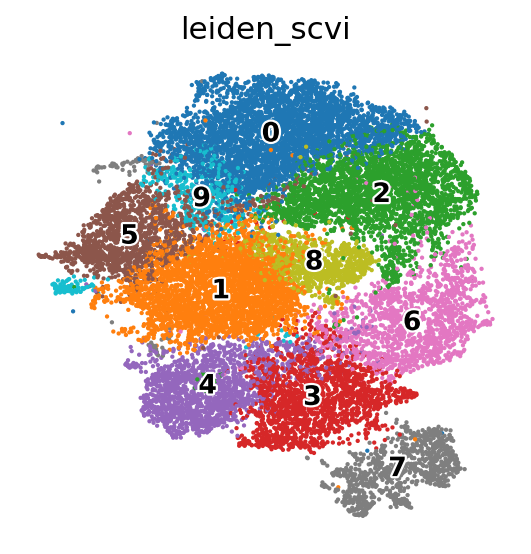

In [5]:
#with rc_context({'figure.figsize': (5, 5)}):
plt.rcParams['svg.fonttype']='none'
sc.pl.umap(ep_ad, color='leiden_scvi', add_outline=False,size=15, legend_loc='on data',title='leiden_scvi',
           legend_fontsize=12, legend_fontoutline=2,frameon=False,
           palette='tab10',show=False)#,save='_col_labeled_by_leiden_scvi.svg')

In [8]:
# gene expression cross correlation
X = pd.DataFrame(ep_ad.X,index=ep_ad.obs_names,columns=ep_ad.var_names)
X['leiden_scvi'] = ep_ad.obs['leiden_scvi']
X_avg = X.groupby('leiden_scvi').mean()
X_corr = X_avg.T.corr()

/tmp/ipykernel_650471/2372892082.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  X_avg = X.groupby('leiden_scvi').mean()


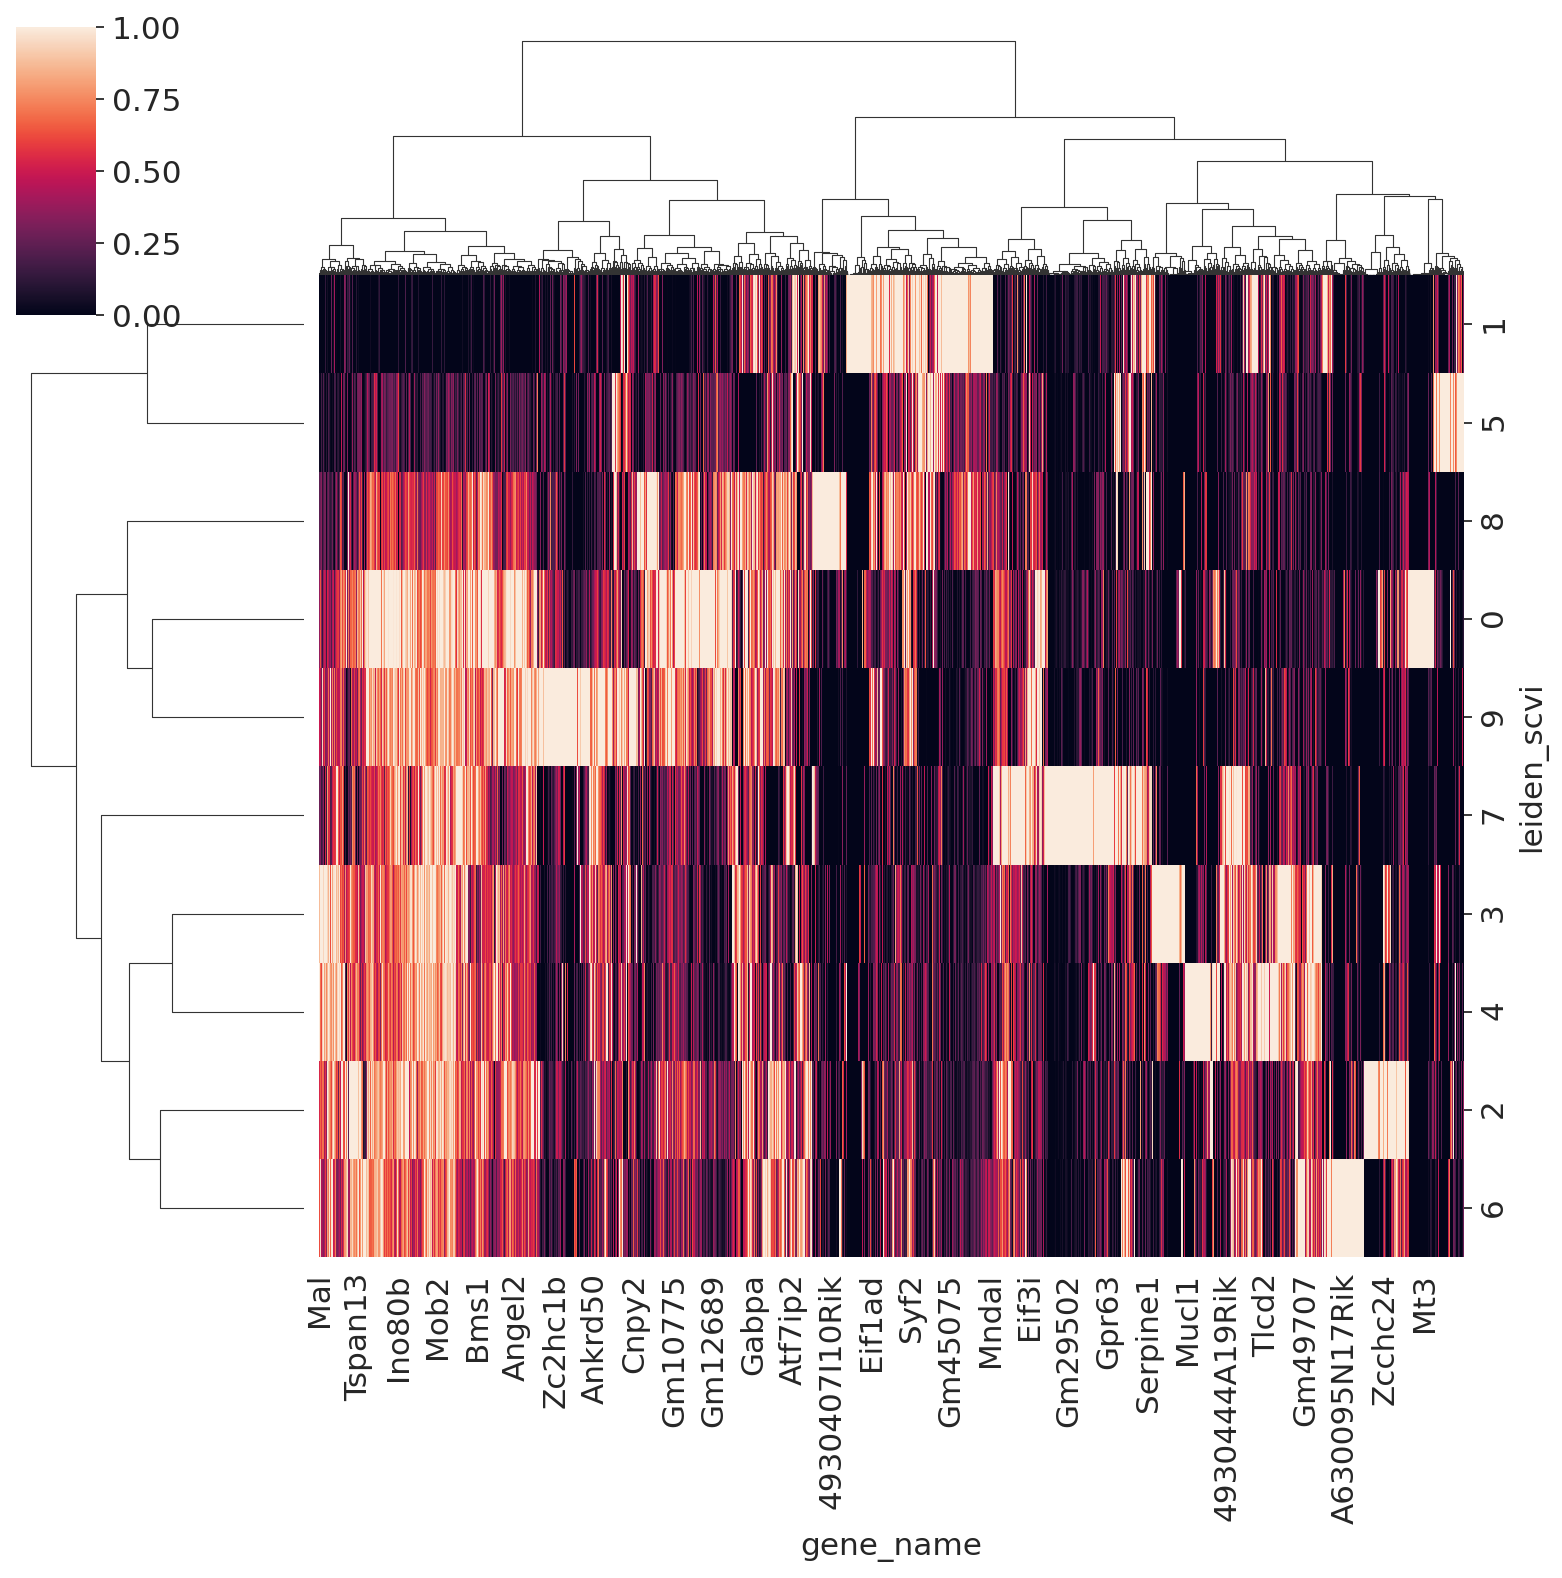

In [12]:
sns.set_style('white')
sns.clustermap(X_avg[X_avg.columns[X_avg.sum(axis=0) != 0].tolist()],standard_scale=1,method='ward')

In [15]:
# cross-correlation of highly expressed hvgs
ep_ad.uns['log1p']['base']=None
ep_hvg_ad = ep_ad.copy()
# genes expressed in at least 10 cells
sc.pp.filter_genes(ep_hvg_ad,min_cells=10,inplace=True)
# consistently variable genes across batches
sc.pp.highly_variable_genes(ep_hvg_ad,batch_key='sample_name')
highly_variable_genes = ep_hvg_ad.var_names[ep_hvg_ad.var.highly_variable]
ep_hvg_ad = ep_hvg_ad[:,highly_variable_genes]

/home/tnoel/anaconda3/envs/myenv_39/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:216: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  disp_grouped = df.groupby('mean_bin')['dispersions']
/home/tnoel/anaconda3/envs/myenv_39/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:216: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  disp_grouped = df.groupby('mean_bin')['dispersions']
/home/tnoel/anaconda3/envs/myenv_39/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:216: FutureWarning: The default of observed=False is deprecated and will be

In [16]:
X_hvg = pd.DataFrame(ep_hvg_ad.X,index=ep_hvg_ad.obs_names,columns=ep_hvg_ad.var_names)
X_hvg['leiden_scvi'] = ep_hvg_ad.obs['leiden_scvi']
X_hvg_avg = X_hvg.groupby('leiden_scvi').mean()
X_hvg_corr = X_hvg_avg.T.corr()

/tmp/ipykernel_650471/1653294524.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  X_hvg_avg = X_hvg.groupby('leiden_scvi').mean()


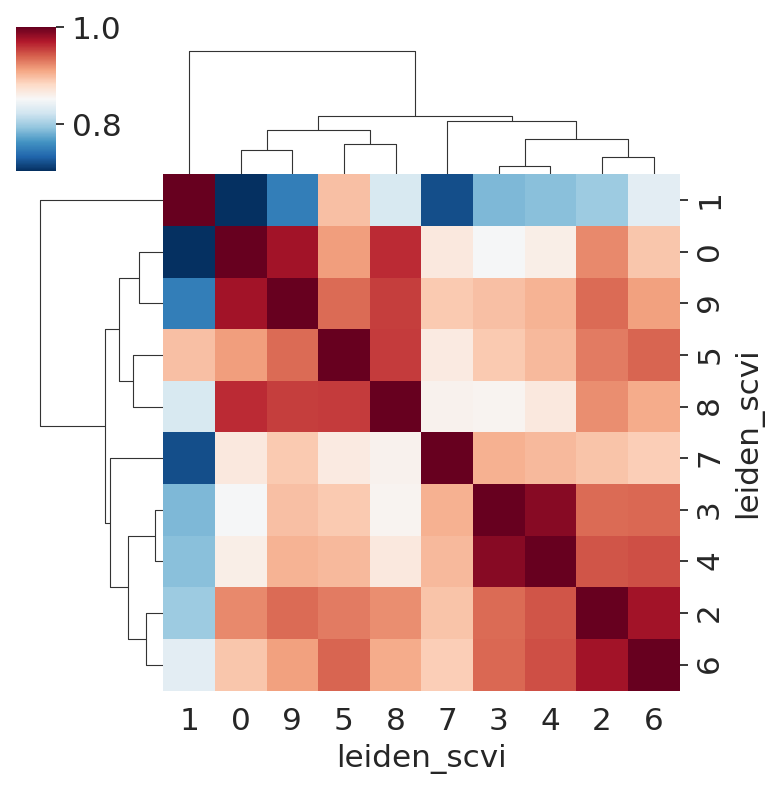

In [19]:
sns.clustermap(X_corr,cmap='RdBu_r',figsize=(5,5))

In [21]:
arr = np.array(X_hvg_avg)
sil_score_d = {}
for i in range(2,10):
    agg_clustering = AgglomerativeClustering(linkage='ward',n_clusters=int(i)).fit(arr)
    labels = agg_clustering.labels_
    sil_score = silhouette_score(arr, labels, metric='euclidean')
    sil_score_d[i] = sil_score
n_clusters=max(sil_score_d, key=sil_score_d.get)

In [22]:
agg_clustering = AgglomerativeClustering(linkage='ward',n_clusters=n_clusters).fit(arr)
agg_clustering_df = pd.DataFrame(agg_clustering.labels_,index=X_hvg_avg.index,columns=['module'])
modules = agg_clustering_df['module']
module_cmap = {}
for i,item in enumerate(np.unique(modules)):
    module_cmap[item] = sns.color_palette('tab10').as_hex()[i]
row_colors = modules.map(module_cmap)

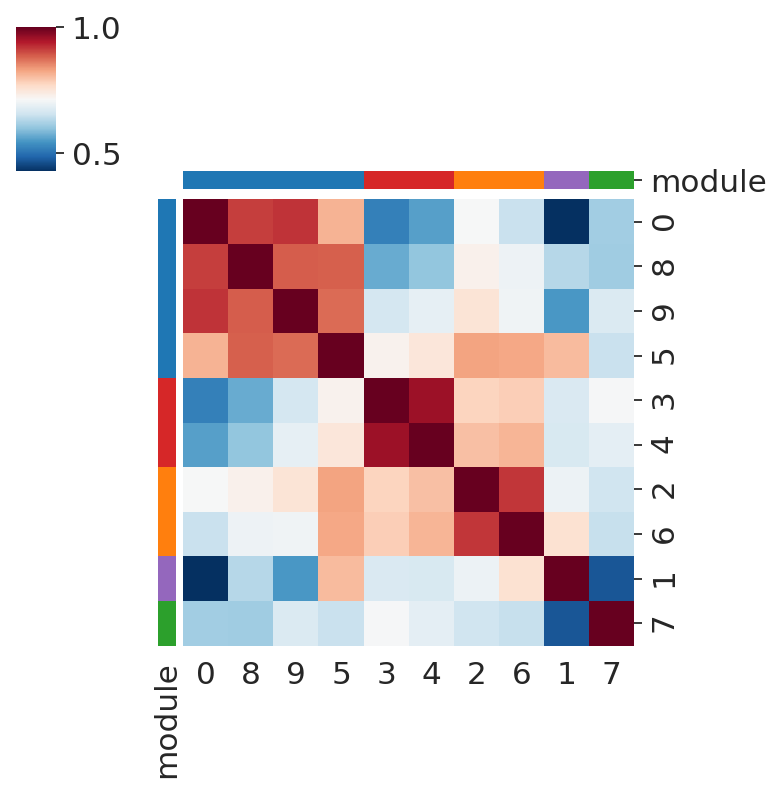

In [23]:
X_hvg_corr = X_hvg_corr.loc[['0','8','9','5','3','4','2','6','1','7']]
X_hvg_corr = X_hvg_corr[['0','8','9','5','3','4','2','6','1','7']]
g = sns.clustermap(X_hvg_corr,cmap='RdBu_r',row_colors=row_colors,col_colors=row_colors,row_cluster=False,col_cluster=False,figsize=(5,5))
ax = g.ax_heatmap
ax.set_xlabel('')
ax.set_ylabel('')
plt.show()

In [20]:
subtype_marker_d = {
    'Basal' : ['Trp63', 'Krt5', 'Krt14','Sox4'],
    'Luminal-intermediate':['Tacstd2','Krt4','Barx2','Ppp1r1b','Sox9','Krt19','Clu','Wfdc2','Ly6a','Ly6e','Ly6d','Prom1'],
    'Luminal-differentiated':['Nkx3-1'],
    'Ar': ['Ar']
}
subtype_gene_list = []
for key in subtype_marker_d.keys():
    value = subtype_marker_d[key]
    for item in value:
        subtype_gene_list.append(item)

In [21]:
sc.tl.dendrogram(ep_norm_ad, var_names = subtype_gene_list,groupby='leiden_scvi',key_added='dendrogram_leiden')

Storing dendrogram info using `.uns['dendrogram_leiden']`


categories: 0, 1, 2, etc.
var_group_labels: Basal, Luminal-intermediate, Luminal-differentiated, etc.


/home/tnoel/anaconda3/envs/myenv_39/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


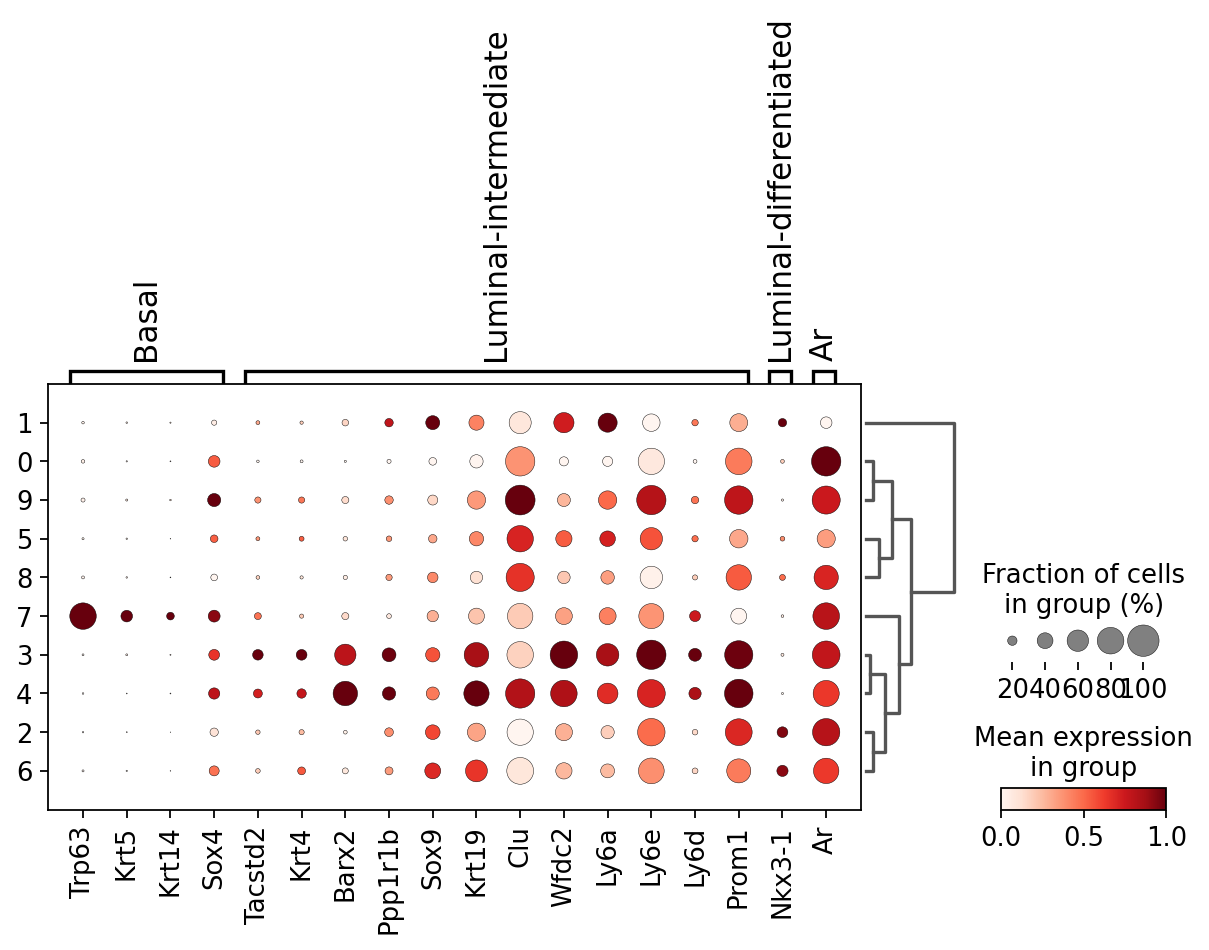

In [22]:
ax = sc.pl.dotplot(ep_norm_ad, subtype_marker_d, groupby='leiden_scvi', standard_scale='var',dendrogram='dendrogram_leiden',
                  show=False)

In [23]:
#(0,8,9), (5), (3,4), (2,6), (1), (7)
subtype_to_clusters = {
    'L2': ['1'],
    'L2.1': ['3','4'],
    'L1.1': ['2','6'],
    'L1.2': ['9','0','8','5'],
    'Basal': ['7']
}
ep_norm_ad.obs['subtype'] = ['unsure']*ep_norm_ad.n_obs
for subtype in subtype_to_clusters.keys():
    ep_norm_ad.obs['subtype'] = np.where(ep_norm_ad.obs['leiden_scvi'].isin(subtype_to_clusters[subtype]), subtype, ep_norm_ad.obs['subtype'])

/home/tnoel/anaconda3/envs/myenv_39/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:378: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


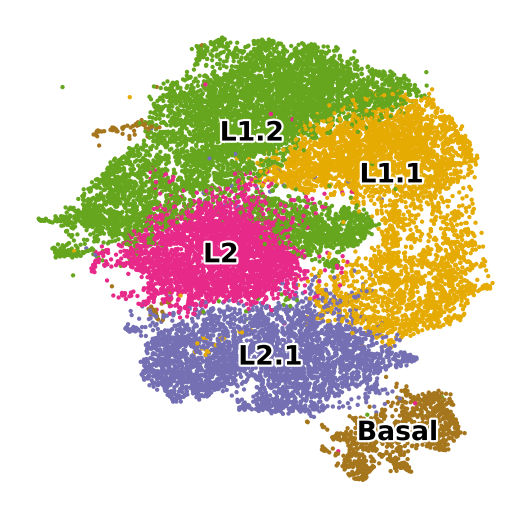

<Figure size 320x320 with 0 Axes>

In [24]:
plt.rcParams['svg.fonttype']='none'
sc.pl.umap(ep_norm_ad, color='subtype', add_outline=False,size=15, legend_loc='on data',title='',
           legend_fontsize=12, legend_fontoutline=2,frameon=False,palette=sns.color_palette('Dark2_r'))
plt.savefig('/local-data/tnoel/Ellis_snRNA/no_epz1_2/paper_figures/umap_col_by_subtype.png',bbox_inches='tight',dpi=300)
plt.savefig('/local-data/tnoel/Ellis_snRNA/no_epz1_2/paper_figures/umap_col_by_subtype.svg',format='svg',bbox_inches='tight',dpi=300)

In [25]:
sc.tl.dendrogram(ep_norm_ad, var_names = subtype_gene_list,groupby='subtype',key_added='dendrogram_subtype')

Storing dendrogram info using `.uns['dendrogram_subtype']`


categories: Basal, L1.1, L1.2, etc.
var_group_labels: Basal, Luminal-intermediate, Luminal-differentiated, etc.


/home/tnoel/anaconda3/envs/myenv_39/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


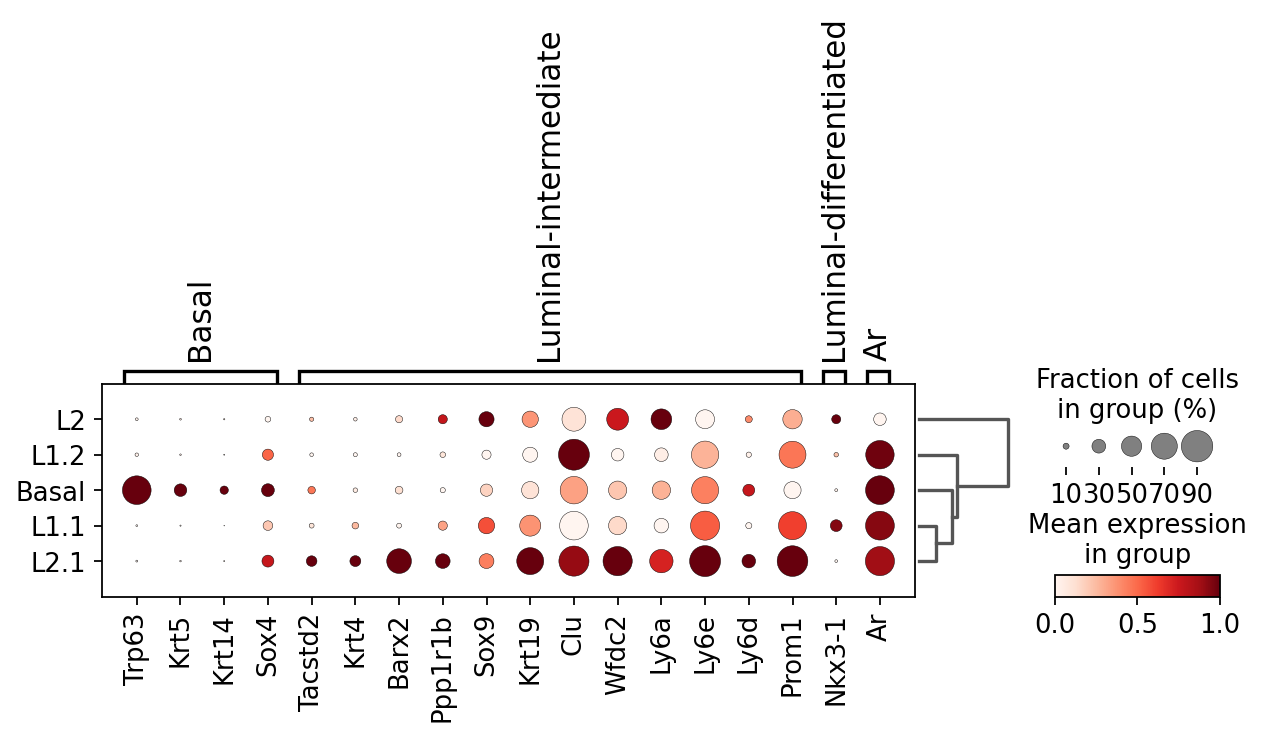

In [26]:
ax = sc.pl.dotplot(ep_norm_ad, subtype_marker_d, groupby='subtype', standard_scale='var',dendrogram='dendrogram_subtype',
                  show=False)

In [27]:
stacked_bar_info = ep_norm_ad.obs[['subtype','treatment_stat']].copy()
stacked_bar_info['treatment_stat'] = [str(x) for x in stacked_bar_info['treatment_stat']]
stacked_bar_info = stacked_bar_info.groupby(['treatment_stat','subtype']).size()

stacked_bar_info = pd.DataFrame(stacked_bar_info)
stacked_bar_info = stacked_bar_info.reset_index()
stacked_bar_info = stacked_bar_info.rename(columns={0:'count'})

stacked_bar_info['pct'] = stacked_bar_info['count'] / stacked_bar_info.groupby('treatment_stat')['count'].transform('sum')
stacked_bar_info = stacked_bar_info.drop(columns={'count'})
stacked_bar_info = stacked_bar_info.pivot(index='treatment_stat', columns='subtype', values='pct')
stacked_bar_info = stacked_bar_info.reset_index()

Text(0.5, 0, '')

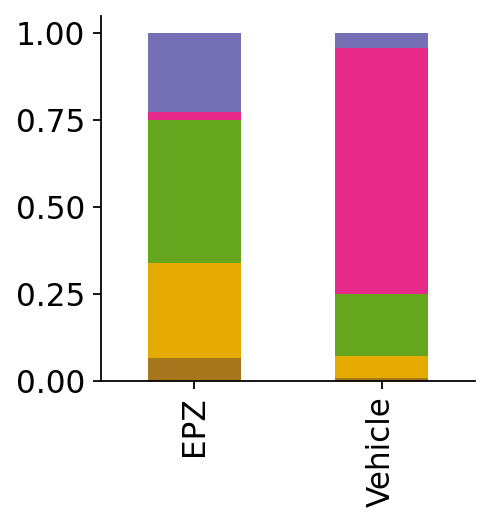

In [57]:
ax = stacked_bar_info.plot(x='treatment_stat', kind='bar', stacked=True,figsize=(3,3),color=sns.color_palette('Dark2_r'),legend=False)
ax.grid(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.xlabel('')